In [7]:
import os
import pandas as pd
from nba_api.stats.static import teams
from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.library.parameters import *
import src.utils as utils
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Normalization
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

nba_teams = teams.get_teams()
fp_team = "./data/all_games.parquet.gzip"

if not os.path.exists(fp_team):
    print("data not found")
    all_games = pd.DataFrame()

    for team in nba_teams:
        team_id = team.get("id")
        gamefinder = leaguegamefinder.LeagueGameFinder(
            team_id_nullable=team_id,
            league_id_nullable=LeagueIDNullable().nba,
            season_type_nullable=SeasonType().regular,
        )

        team_games = gamefinder.get_data_frames()[0]
        all_games = pd.concat([all_games, team_games])
    all_games.to_parquet(fp_team, index=False)
else:
    print("data found local")
    all_games = pd.read_parquet(fp_team)

franchise_founding_dates = {team["id"]: team["year_founded"] for team in nba_teams}

all_games["GAME_DATE"] = pd.to_datetime(all_games["GAME_DATE"])
all_games = all_games.sort_values(["GAME_DATE", "GAME_ID"]).reset_index(drop=True)

# Apply the function to calculate plus-minus
all_games = utils.calculate_plus_minus(all_games)
all_games["DAYS_SINCE_LAST_GAME"] = (
    all_games.groupby(["SEASON_ID", "TEAM_ID"])["GAME_DATE"].diff().dt.days
)
# all_games.tail(20).to_csv('all_games_lastTwentyRows.csv', index=False)
curr_game_cols = all_games.columns
all_games = utils.calculate_recent_performance(all_games, windows=[3, 7, 10])


data found local


In [8]:
# Define the features and targets
data = all_games.copy()

target_win = "WL"
target_plus_minus = "PLUS_MINUS"

# Convert WL to boolean
data[target_win] = data[target_win].apply(lambda x: 1 if x=='W' else 0)

# Define meta columns that are not features
meta_cols = [
    "SEASON_ID",
    "TEAM_ID",
    "TEAM_ABBREVIATION",
    "TEAM_NAME",
    "GAME_ID",
    "GAME_DATE",
    "MATCHUP",
    "HOME_GAME",
]

# Define the feature columns
excl_cols = list(set(np.append(target_win, np.append(target_plus_minus, np.append(curr_game_cols, meta_cols)))))
feature_cols = [col for col in data.columns if col not in excl_cols]

# Separate home and away features
home_games = data[data["HOME_GAME"]].set_index("GAME_ID")
away_games = data[~data["HOME_GAME"]].set_index("GAME_ID")

# Ensure the indices (GAME_ID) are aligned
home_games = home_games.loc[home_games.index.isin(away_games.index)].fillna(0)
away_games = away_games.loc[home_games.index].fillna(0)

# Features for home and away teams
home_features = home_games[feature_cols]
away_features = away_games[feature_cols]

display(home_features)
# Targets for home games
home_targets = home_games[[target_win, target_plus_minus]].dropna()
home_targets['PLUS_MINUS'] = home_targets['PLUS_MINUS'].abs()
home_targets['WL'].value_counts(normalize=True)
home_features.columns

,AVG_3_GAME_PLUS_MINUS,AVG_3_GAME_FGM,AVG_3_GAME_FGA,AVG_3_GAME_FG_PCT,AVG_3_GAME_FG3M,AVG_3_GAME_FG3A,AVG_3_GAME_FG3_PCT,AVG_3_GAME_FTM,AVG_3_GAME_FTA,AVG_3_GAME_FT_PCT,...,AVG_10_GAME_FT_PCT,AVG_10_GAME_OREB,AVG_10_GAME_DREB,AVG_10_GAME_REB,AVG_10_GAME_AST,AVG_10_GAME_STL,AVG_10_GAME_BLK,AVG_10_GAME_TOV,AVG_10_GAME_PF,WIN_PCT_10_GAMES
GAME_ID,,,,,,,,,,,,,,,,,,,,,
0028300001,6.000000,41.333333,84.666667,0.486333,13.000000,35.666667,0.366000,16.000000,18.333333,0.892667,...,0.8566,8.7,35.1,43.8,27.6,8.3,3.9,12.5,16.3,0.7
0028300002,-18.666667,34.333333,96.666667,0.355333,9.000000,38.000000,0.244667,16.000000,21.000000,0.771000,...,0.7599,15.1,33.0,48.1,24.5,6.7,2.9,14.8,18.2,0.2
0028300003,16.666667,55.000000,96.000000,0.570667,14.666667,37.666667,0.388333,14.333333,18.333333,0.786667,...,0.8298,10.4,31.5,41.9,31.0,7.0,5.8,10.6,21.1,0.7
0028300004,-3.000000,42.000000,90.666667,0.466667,13.000000,35.666667,0.373667,14.000000,19.000000,0.736667,...,0.7694,10.5,38.0,48.5,32.1,6.1,6.7,16.5,15.4,0.6
0028300005,-8.333333,38.333333,77.000000,0.498333,10.666667,31.000000,0.349667,20.000000,27.000000,0.723333,...,0.7587,8.8,32.6,41.4,27.8,9.7,6.4,13.3,17.6,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0022301196,21.000000,44.333333,90.000000,0.493667,13.333333,35.333333,0.376667,19.333333,24.000000,0.817333,...,0.8011,8.6,33.5,42.1,27.9,9.6,6.5,13.4,16.9,0.6
0022301197,-7.333333,39.666667,89.333333,0.448333,11.333333,37.666667,0.310000,13.333333,17.000000,0.832000,...,0.7822,9.8,37.3,47.1,31.1,6.2,6.5,15.9,15.2,0.6
0022301198,5.666667,41.000000,81.000000,0.507000,17.000000,36.666667,0.453000,15.333333,20.666667,0.743000,...,0.8357,10.5,36.5,47.0,30.0,8.0,6.2,14.9,18.0,0.8


Index(['AVG_3_GAME_PLUS_MINUS', 'AVG_3_GAME_FGM', 'AVG_3_GAME_FGA',
       'AVG_3_GAME_FG_PCT', 'AVG_3_GAME_FG3M', 'AVG_3_GAME_FG3A',
       'AVG_3_GAME_FG3_PCT', 'AVG_3_GAME_FTM', 'AVG_3_GAME_FTA',
       'AVG_3_GAME_FT_PCT', 'AVG_3_GAME_OREB', 'AVG_3_GAME_DREB',
       'AVG_3_GAME_REB', 'AVG_3_GAME_AST', 'AVG_3_GAME_STL', 'AVG_3_GAME_BLK',
       'AVG_3_GAME_TOV', 'AVG_3_GAME_PF', 'WIN_PCT_3_GAMES',
       'AVG_7_GAME_PLUS_MINUS', 'AVG_7_GAME_FGM', 'AVG_7_GAME_FGA',
       'AVG_7_GAME_FG_PCT', 'AVG_7_GAME_FG3M', 'AVG_7_GAME_FG3A',
       'AVG_7_GAME_FG3_PCT', 'AVG_7_GAME_FTM', 'AVG_7_GAME_FTA',
       'AVG_7_GAME_FT_PCT', 'AVG_7_GAME_OREB', 'AVG_7_GAME_DREB',
       'AVG_7_GAME_REB', 'AVG_7_GAME_AST', 'AVG_7_GAME_STL', 'AVG_7_GAME_BLK',
       'AVG_7_GAME_TOV', 'AVG_7_GAME_PF', 'WIN_PCT_7_GAMES',
       'AVG_10_GAME_PLUS_MINUS', 'AVG_10_GAME_FGM', 'AVG_10_GAME_FGA',
       'AVG_10_GAME_FG_PCT', 'AVG_10_GAME_FG3M', 'AVG_10_GAME_FG3A',
       'AVG_10_GAME_FG3_PCT', 'AVG_10_GAME_FTM', '

In [9]:
# Split the data into training and testing sets while keeping the index for correspondence
X_home_train, X_home_test, y_home_train, y_home_test = train_test_split(home_features, home_targets, test_size=0.2, random_state=42)
X_away_train, X_away_test = away_features.loc[X_home_train.index], away_features.loc[X_home_test.index]

tf.keras.backend.clear_session()

# Normalize the input features
normalizer_home = Normalization()
normalizer_home.adapt(X_home_train.to_numpy())

normalizer_away = Normalization()#axis=-1)
normalizer_away.adapt(X_away_train.to_numpy())

# Define model inputs
home_input = Input(shape=(len(X_home_train.columns),), name="home_input")
away_input = Input(shape=(len(X_away_train.columns),), name="away_input")

# Apply normalization
norm_home = normalizer_home(home_input)
norm_away = normalizer_away(away_input)

# Concatenate the inputs
concatenated = Concatenate()([norm_home, norm_away])

# Define the rest of the model
dense1 = Dense(128, activation='relu')(concatenated)
dense2 = Dense(64, activation='relu')(dense1)
dense3 = Dense(32, activation='relu')(dense2)
dense4 = Dense(16, activation='relu')(dense3)

# Output layer for binary classification (Home win or not)
output_home_win = Dense(1, activation='sigmoid', name="home_win")(dense4)

# Output layer for regression (Point difference)
output_point_diff = Dense(1, name="point_diff")(dense4)

# Create the model
model = Model(inputs=[home_input, away_input], outputs=[output_home_win, output_point_diff])

# Compile the model
model.compile(optimizer='adam',
              loss={'home_win': 'binary_crossentropy', 'point_diff': 'mean_squared_error'},
              metrics={'home_win': 'accuracy', 'point_diff': 'mse'})

In [10]:
# Train the model
history = model.fit(
    [X_home_train, X_away_train], 
    {'home_win': y_home_train[target_win], 'point_diff': y_home_train[target_plus_minus]},
    validation_data=([X_home_test, X_away_test], 
                     {'home_win': y_home_test[target_win], 'point_diff': y_home_test[target_plus_minus]}),
    epochs=20,
    batch_size=32
)

# Save the model
model.save('home_away_model.keras')

# Evaluate the model
results = model.evaluate([X_home_test, X_away_test], 
                         {'home_win': y_home_test[target_win], 'point_diff': y_home_test[target_plus_minus]})

print("Test Loss, Test Accuracy, Test MSE:", results)


Epoch 1/20
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 1s 704us/step - home_win_accuracy: 0.5236 - loss: 75.4428 - point_diff_mse: 74.6639 - val_home_win_accuracy: 0.6057 - val_loss: 67.0220 - val_point_diff_mse: 66.3608
Epoch 2/20
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 1s 573us/step - home_win_accuracy: 0.6142 - loss: 64.7767 - point_diff_mse: 64.1216 - val_home_win_accuracy: 0.6510 - val_loss: 65.8220 - val_point_diff_mse: 65.1923
Epoch 3/20
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 1s 570us/step - home_win_accuracy: 0.6414 - loss: 64.3857 - point_diff_mse: 63.7509 - val_home_win_accuracy: 0.6587 - val_loss: 65.9858 - val_point_diff_mse: 65.3634
Epoch 4/20
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 1s 582us/step - home_win_accuracy: 0.6456 - loss: 64.3144 - point_diff_mse: 63.6865 - val_home_win_accuracy: 0.6501 - val_loss: 66.0021 - val_point_diff_mse: 65.3802
Epoch 5/20
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 1s 570us/step - home_win_accuracy: 0.6454 - loss: 64.0691 - point_diff_mse: 63.4445 - val_home_win_accuracy: 0.6399 - val_loss

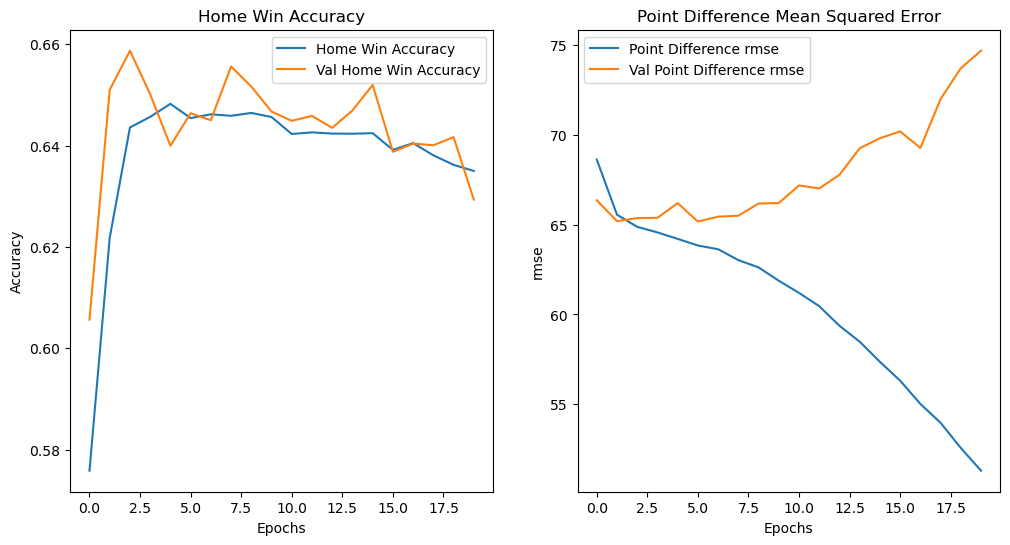

In [11]:
# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['home_win_accuracy'], label='Home Win Accuracy')
    plt.plot(history.history['val_home_win_accuracy'], label='Val Home Win Accuracy')
    plt.title('Home Win Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['point_diff_mse'], label='Point Difference rmse')
    plt.plot(history.history['val_point_diff_mse'], label='Val Point Difference rmse')
    plt.title('Point Difference Mean Squared Error')
    plt.xlabel('Epochs')
    plt.ylabel('rmse')
    plt.legend()

    plt.show()

plot_history(history)